## Setup

There are some external libraries necessary for running the notebook. They are listed in `requirements.txt` and can be installed with pip or conda like:
```
pip install -r requirements.txt
```
```
conda install --yes --file requirements.txt
```

As usual, using a virtual environment like venv or isolated conda environment is recommended.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
%run -i utility_functions.py # running utility_functions.py in IPython's namespace, importing the functions

# Lab for loading and transforming the data
Responsible: Fabian (01126693)

## Task

As group 5 we have chosen task 6. Task 6 deals with natural disasters and poses 3 questions to be answered:

1. How did the number of deaths per year from natural disasters change over the last years? 
2. How does this vary by country? How does this vary by type of natural disaster?  
3. Are there trends visible that could be due to climate change? 

Based on the questions posed, some requirements for the data set emerge. Question 1 aims at the change in death counts over the last years. Therefore, the dataset must contain death counts as well as a history as long as possible (optimally in the range of 100 years). Question 2 focuses on the development in different countries and whether there are differences between different types of natural disasters. Therefore, the data set must include both geographic characteristics and attributes to distinguish between different types of natural disasters. 

## Data Source(s)
Based on these requirements, publicly available datasets were sought. The 2 most relevant of these are presented briefly here and an explanation is given of how the final choice of dataset was made. 

### WHO data [<sup>1</sup>](#fn1) ( Explored but not used)

The data was queried from the Mortality Database provided by the WHO. With regard to the origin, completeness and scope of the data, the WHO says: 

> The WHO Mortality Database is a compilation of mortality data by country and area, year, sex, age and cause of death, as transmitted annually by national authorities from their civil registration and vital statistics system. It comprises data since 1950 to date. Only data with at least 65% completeness are published here

##### Requirements met
 - Total death counts per year 
 - Split by country and geographical region 
 - Split by sex (additional information)
 - Split by age (additional information)

##### Requirements not met
 - Long history missing: data for natural disasters starts 1979
 - Missing split by type of natural disaster
 
It can be seen that the WHO data are more detailed in terms of gender and age categories, but they have no distinction of natural disaster categories and also have a limited history of only 50 years. 

### EM-DAT data [<sup>2</sup>](#fn2) (Explored and used)

> In 1988, the Centre for Research on the Epidemiology of Disasters (CRED) launched the Emergency  Events Database (EM-DAT). EM-DAT was created with the initial support of the World Health Organisation (WHO) and the Belgian Government.
>
>The main objective of the database is to serve the purposes of humanitarian action at national and international levels. The initiative aims to rationalise decision making for disaster preparedness, as well as provide an objective base for vulnerability assessment and priority setting.
>
>EM-DAT contains essential core data on the occurrence and effects of over 22,000 mass disasters in the world from 1900 to the present day. The database is compiled from various sources, including UN agencies, non-governmental organisations, insurance companies, research institutes and press agencies.
>
> -- Source: https://www.emdat.be/

##### Requirements met
 - Total death counts per event 
 - Country, region and continent information per event
 - Events dated back till 1900
 - Disaster type per event
 
Since the questions do not require an analysis based on gender or age categories, but the EM-DAT dataset covers a much longer period (since 1900) and also assigns a category to each natural disaster, this dataset is perfectly suited for the task and therefore used for the analysis. The database is event based and covers all events for which at least one of the following criteria is fulfilled [<sup>3</sup>](#fn3): 

 - 10 or more people reported killed
 - 100 or more people reported affected
 - Declaration of a state of emergency
 - Call for international assistance


In the following section, a detailed overview of the attributes used in the further analysis will be given. 

#### Data fields

 - `Disaster_Group`: Two different types of disasters can be distinguished in the EM-DAT database: natural disasters and technological disasters. Since we are only interested in natural disasters, only they were requested and consequently this field contains only the value *Natural*. No missing values are present for this attribute. 
 - `Disaster_Subgroup`: Every natural disaster is assigned to one of the following six subgroups: *Biological, Geophysical, Climatological, Hydrological, Meteorological and Extra-terrestrial* to describe the type of natural disaster. No missing values are present for this attribute. 
 - `Disaster_type`: For every natural disaster event one main disaster type is identified. If two or more disasters are related because they are consequences of each other, then this information is encoded in the attributes `Associated_Dis` and `Associated_Dis2`. No missing values are present for this attribute. 
 
 - `Disaster Sub-Type`: Subdivision related to the attribute `Disaster_type` so that a the disaster type Storm can be further classified as tropical, extra-tropical or convective storm. 
 
 - `Disaster Sub-Sub Type`: Any appropriate sub-division of the disaster sub-type (not applicable for all disaster sub-types).
 
> Types of natural disasters could be further broken down using two more categories which would be available in the database. For example, the Disaster type *Storm* could be further subdivided into *Tropical storm*, *Extra-tropical storm* or *Convective storm*. Even a further subdivision of the category *Convective storm* would be possible. Since the analysis is aimed at detecting trends on a high level, the classification of each event based on the attributes `Disaster_Subgroup` and `Disaster _Type` was considered sufficient and the further subdivisions into `Disaster sub-type` and `Disaster Subsubtype` is only intended to be considered for detailed analysis. The full table is saved in /data/disaster_classification (w/o the technological disaster group) and shown in the Appendix of this notebook.

 - `Associated_Dis`: Secondary event triggered by a natural disaster (i.e. Landslide for a flood, explosion after an earthquake, ...)
 - `Associated_Dis2`: Another secondary event triggered by a natural disaster. (i.e. Landslide for a flood, explosion after an earthquake, ...)
 
 Example: If a tsunami is triggered by an earthquake, then the attribute `Disaster_Type` would be *Earthquake*, the attribute `Disaster_Subtype` would be *Ground movement* and the attribute `Associated_Dis` would be *Tsunami/Tidal wave*.
 
 - `Country`: The country in which the disaster has occurred or had an impact. If a disaster has affected more than one country, a seperate entry is created in the database for each country affected. No missing values are present for this attribute. 
 - `ISO`: Unique 3-letter code for each country defined by ISO 3166. No missing values are present for this attribute. 
 - `Region`: The region to which the country belongs, based on the UN regional division. No missing values are present for this attribute. 
 - `Continent`: The continent to which the country belongs. No missing values are present for this attribute. 
 - `Start_Year`: The year when the disaster occurred. No missing values are present for this attribute.
 
 - `End Year`: The year when the disaster ended. No missing values are present for this attribute.
 
> For sudden-impact disasters also the month and the day are well defined and available. For disaster situations developing gradually over a longer time period (i.e. drought) with no specific start date the day attribute is empty. For our questions the exact date plays a subordinate role and therefore the year of the beginning of the disaster is completely sufficient for our analysis.    

 - `Total_Deaths`: Number of people who lost their life because the event happened plus the number of people whose whereabouts since the disaster are unknown, and presumed dead based on official figures. Missing values present for approx. 25% of all events.
 
 - `No_Affected`: Number of people which requiring immediate assistance during an emergency situation. The indicator affected is often reported and is widely used by different actors to convey the extent, impact, or severity of a disaster in non-spatial terms. In case that no values for the attribute `Total_Deaths` are available this attribute could be used as a proxy.

Loading the disaster classification mapping, according to EM-DAT.

In [38]:
disaster_classification: pd.DataFrame = pd.read_csv("../data/disaster_classification.csv")
disaster_subgroups = set(disaster_classification.loc[disaster_classification["Disaster Sub-Group"].notna(), "Disaster Sub-Group"])

### Load - Transform - Explore - Export

The next steps are to load the data, assign a corresponding data type to each column, and give a brief overview of the data. The detailed analysis of the data set happens in the course of the answering of the questions defined above further down in the notebook. Since the data doesn't cover the whole year 2022, those records are exluded from the analysis in order to have only event data of entire years.

In [39]:
raw_xlsx = pd.read_excel("../data/emdat.xlsx",
                         skiprows = 5,
                         header = 1,
                         usecols = ['Disaster Group',
                                    'Disaster Subgroup',
                                    'Disaster Type',
                                    'Disaster Subtype',
                                    'Disaster Subsubtype',
                                    'Associated Dis',
                                    'Associated Dis2',
                                    'Country',
                                    'ISO',
                                    'Region',
                                    'Continent',
                                    'Start Year',
                                    'End Year',
                                    'Total Deaths',
                                    'Total Affected'])
raw_xlsx.columns = raw_xlsx.columns.str.replace(' ', '_') # replace all spaces in header names
raw_xlsx.head()

C:\Users\Koffe\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Disaster_Group,Disaster_Subgroup,Disaster_Type,Disaster_Subtype,Disaster_Subsubtype,Country,ISO,Region,Continent,Associated_Dis,Associated_Dis2,Start_Year,End_Year,Total_Deaths,Total_Affected
0,Natural,Climatological,Drought,Drought,NaN,Cabo Verde,CPV,Western Africa,Africa,Famine,NaN,1900,1900,11000.0,NaN
1,Natural,Climatological,Drought,Drought,NaN,India,IND,Southern Asia,Asia,NaN,NaN,1900,1900,1250000.0,NaN
2,Natural,Geophysical,Earthquake,Ground movement,NaN,Guatemala,GTM,Central America,Americas,Tsunami/Tidal wave,NaN,1902,1902,2000.0,NaN
3,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Guatemala,GTM,Central America,Americas,NaN,NaN,1902,1902,1000.0,NaN
4,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Guatemala,GTM,Central America,Americas,NaN,NaN,1902,1902,6000.0,NaN


In [40]:
df_transformed = pd.DataFrame() 
df_transformed = raw_xlsx.convert_dtypes() # assign meaningful data types
print(df_transformed.dtypes) # check data types
df_transformed = df_transformed[(df_transformed['Start_Year'] != 2022)] # filter out data from 2022

Disaster_Group         string
Disaster_Subgroup      string
Disaster_Type          string
Disaster_Subtype       string
Disaster_Subsubtype    string
Country                string
ISO                    string
Region                 string
Continent              string
Associated_Dis         string
Associated_Dis2        string
Start_Year              Int64
End_Year                Int64
Total_Deaths            Int64
Total_Affected          Int64
dtype: object


In [41]:
print(df_transformed.shape[0]) # check number of records
print(df_transformed['Total_Deaths'].isna().sum() ) # check number of NA values
print(df_transformed['Start_Year'].min()) # get first year of records
print(df_transformed['Start_Year'].max()) # get last year of records

df_transformed['Disaster_Decade'] = df_transformed['Start_Year']//10*10 # assign every year to the correspondig decade
print(df_transformed["Total_Deaths"].isnull().groupby(df_transformed.Disaster_Decade).sum().astype(int)) # NA values per decade
print(df_transformed["Total_Deaths"].isnull().groupby(df_transformed.Continent).sum().astype(int)) # NA values per continent 

16132
4647
1900
2021
Disaster_Decade
1900       8
1910      18
1920      20
1930      16
1940      28
1950      26
1960     142
1970     256
1980     613
1990     897
2000    1301
2010    1033
2020     289
Name: Total_Deaths, dtype: int32
Continent
Africa       947
Americas    1309
Asia        1240
Europe       798
Oceania      353
Name: Total_Deaths, dtype: int32


#### Missing data

As discussed earlier, data is collected from multiple sources and therefore there is always the possibility of missing values. The data set contains a total of 16.132 recorded events starting from 1900 up to 2021. For the attribute `Total Deaths` it can be seen that 4.647 records have a missing value which corresponds to a portion of approximately 29% of missing values. Due to the nature of the available data, interpolation of missing values is not appropriate, as disasters can vary significantly in severity, location, and number of people killed. One way to approximate the missing data in terms of deaths is to use the number of affected. However, it must be taken into account that this number is sometimes considerably different from the number of deaths and always overestimates them. Looking at the distribtuion of missing values per decade one can see that the majority of records is from the 1980s or later. When it comes to geografical location of the records with missing data one can observe that the majority of disasters are linked to Americas and Asia. 


## Temperature Data
By Moritz Renkin (11807211)
The temperature data is necessary only for the question regarding climate change. We use two different datasets in order to investigate a possible relation between natural disasters and global warming, as outlined below.

### Temperature Delta per Country (Berkeley)
Berkeley Earth gathers temperature data from different sources all around the globe. An overview over their methodology and data sources is available [here](https://berkeleyearth.org/data/) and its absolute uncertainty (95% range). The specific dataset for this case study is already aggregated per Country and contains the calculated Warming/Century per Country. It is available at: [https://berkeleyearth.lbl.gov/country-list/](https://berkeleyearth.lbl.gov/country-list/).
The main reason for choosing Berkeley Earth's dataset is that is thoroughly bias-corrected, in contrast to other common sources such as the World Bank API.

In [70]:
country_temp_delta = pd.read_csv("../data/country_temp_delta.csv", index_col="Country")

The "Warming since..." column needs to be split into a warming and uncertainty column.

In [44]:
country_temp_delta[["Warming/Century", "Uncertainty (±)"]] = country_temp_delta["Warming since 1960 (°C / century)"].str.split("±", expand=True).apply(pd.to_numeric, errors="coerce")
country_temp_delta.drop("Warming since 1960 (°C / century)", inplace=True, axis=1)
country_temp_delta

,Region,Warming/Century,Uncertainty (±)
Country,,,
Afghanistan,Asia,3.32,0.34
Åland,Europe,3.01,0.24
Albania,Europe,1.97,0.28
Algeria,Africa,2.86,0.28
American Samoa,NaN,1.43,0.57
...,...,...,...
Virgin Islands,NaN,1.88,0.30
Western Sahara,Africa,2.49,0.69
Yemen,Asia,2.50,0.55


### Global temperature delta per year
Loading the NASA yearly global temperature data, source: [https://climate.nasa.gov/vital-signs/global-temperature/](https://climate.nasa.gov/vital-signs/global-temperature/)

In [45]:
yearly_global_temp: pd.DataFrame = pd.read_csv("../data/nasa_yearly_global_temperature.csv", index_col="Year").rename(columns={"Temp_No_Smoothing": "Temperature Delta"})
yearly_global_temp

,Temperature Delta,Temp_Lowess(5)
Year,,
1880,-0.18,-0.10
1881,-0.09,-0.14
1882,-0.11,-0.17
1883,-0.17,-0.20
1884,-0.28,-0.24
...,...,...
2017,0.92,0.91
2018,0.85,0.92
2019,0.98,0.93


<sup>1</sup> WHO data: <span id="fn1"> https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/natural-disasters</span>

<sup>2</sup> EM-dat data: <span id="fn2"> https://public.emdat.be/data Based on the terms of use, the data can be used for this exercise:  
    
> If you are an academic organization, a university, a non-profit research institution and/or an international public organization (UN agencies, multi-lateral banks, other multilateral institution and national governments) and/or part of a Media agency (journalist, press agencies) with the intention to use the EM-DAT database (hereafter ‘EM-DAT’) for research, teaching or information purposes, you shall, conditional upon the acceptance of the present conditions of use, be granted free access to EM-DAT (also ‘Authorized Use’).
    
<sup>3</sup> EM-dat data: <span id="fn3"> https://www.emdat.be/explanatory-notes

## 1. How did the number of deaths per year from natural disasters change over the last years? 

In [46]:
df_a = df_transformed
df_a = df_a.astype({"Total_Deaths": np.float64, "Total_Affected": np.float64, "Start_Year": np.int32, "Disaster_Decade":np.int32})

In [47]:
print(df_a.sum()['Total_Deaths']/(df_a.max()['Start_Year']-df_a.min()['Start_Year']+1))
cutoff_date = 1921 
df_a_100 = df_a[df_a["Start_Year"] > cutoff_date]
print(df_a_100.sum()['Total_Deaths']/(df_a_100.max()['Start_Year']-df_a_100.min()['Start_Year']+1))
cutoff_date = 1971 
df_a_50 = df_a[df_a["Start_Year"] > cutoff_date]
print(df_a_50.sum()['Total_Deaths']/(df_a_50.max()['Start_Year']-df_a_50.min()['Start_Year']+1))

265986.7950819672
202370.5
65795.8


C:\Users\Koffe\AppData\Local\Temp\ipykernel_11436\3482101558.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_a.sum()['Total_Deaths']/(df_a.max()['Start_Year']-df_a.min()['Start_Year']+1))
C:\Users\Koffe\AppData\Local\Temp\ipykernel_11436\3482101558.py:4: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_a_100.sum()['Total_Deaths']/(df_a_100.max()['Start_Year']-df_a_100.min()['Start_Year']+1))
C:\Users\Koffe\AppData\Local\Temp\ipykernel_11436\3482101558.py:7: FutureWarning: The default value of numeric_only in DataF

Natural disasters killed globally on average 266 thousand people per year over the last 122 years. 
This average lowers to 202 thousand when only having a look at the last 100 years.
There died on average 66 thousand people per year in the last 50 years.

C:\Users\Koffe\AppData\Local\Temp\ipykernel_11436\688548717.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = df_a.groupby(["Start_Year"]).mean()['Total_Deaths'].round()


Text(0.5, 1.0, 'Average of deaths per natural disaster over years')

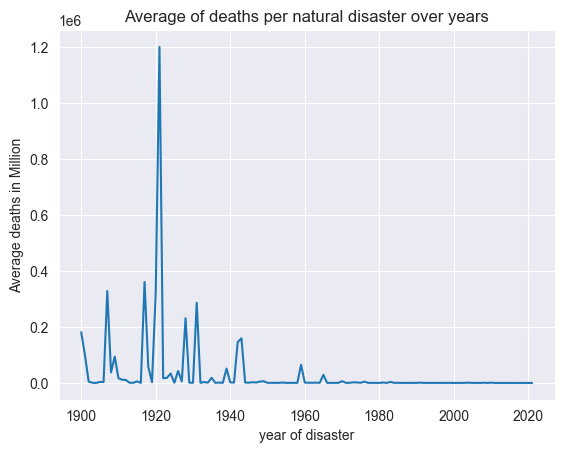

In [48]:
# calc mean deaths per disaster over the years

means = df_a.groupby(["Start_Year"]).mean()['Total_Deaths'].round()
ax = means.plot(kind = 'line')
ax.set_ylabel('Average deaths in Million')
ax.set_xlabel ('year of disaster')
ax.set_title('Average of deaths per natural disaster over years')

The graphic shows how many people died on average per natural disaster per year. As there is only one event with 1.2 million death in 1921 it leads to that big spike. Therefor we decided to use decades instead of years.

C:\Users\Koffe\AppData\Local\Temp\ipykernel_11436\3243352624.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = df_a.groupby(["Disaster_Decade"]).mean()['Total_Deaths'].round()


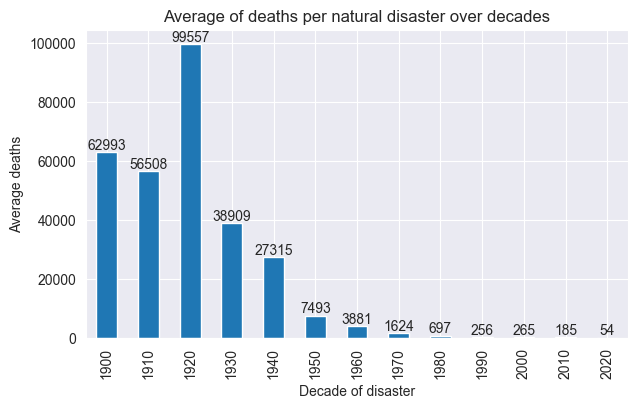

In [49]:
# calc mean deaths, per Decade and plot them in a bar plot
means = df_a.groupby(["Disaster_Decade"]).mean()['Total_Deaths'].round()
ax = means.plot(kind = 'bar', figsize = (7,4))
ax.set_ylabel('Average deaths')
ax.set_xlabel ('Decade of disaster')
ax.set_title('Average of deaths per natural disaster over decades')
ax.bar_label(ax.containers[0])
plt.show()

When having a look at the average deaths per decade per natural disaster, it can be seen that there was a peek in the 1920th and the number of deaths decreased over the years. However, this does not automatically mean that the number of natural disasters is decreasing. 

C:\Users\Koffe\AppData\Local\Temp\ipykernel_11436\689409622.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medians = df_a.groupby(["Disaster_Decade"]).median()['Total_Deaths']


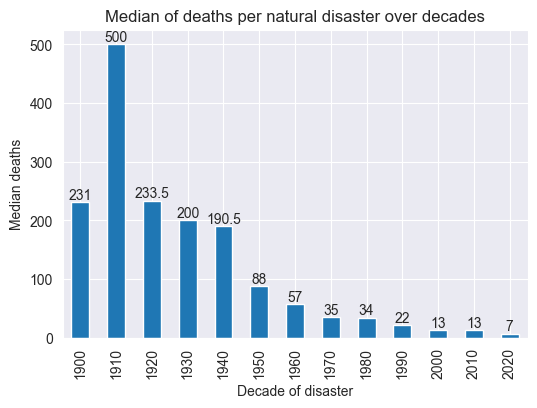

In [50]:
# calc median deaths, per Decade and plot them in a bar plot
medians = df_a.groupby(["Disaster_Decade"]).median()['Total_Deaths']
ax = medians.plot(kind = 'bar', figsize = (6,4))
ax.set_ylabel('Median deaths')
ax.set_xlabel ('Decade of disaster')
ax.set_title('Median of deaths per natural disaster over decades')
ax.bar_label(ax.containers[0])
plt.show()

The median compared to the mean shows that there seem to have been some events in 1920 leading to a really high number of deaths. Still we can see, that the number of deaths have significantly decreased in the last 90 years.

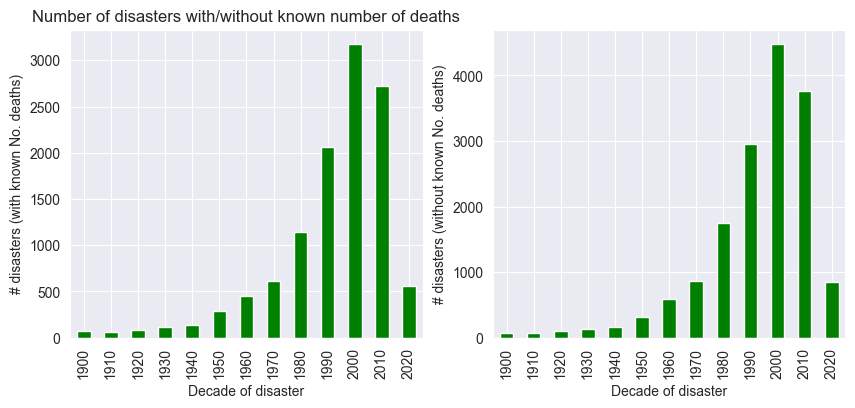

Disaster_Decade
1900      79
1910      77
1920     106
1930     135
1940     170
1950     310
1960     593
1970     871
1980    1755
1990    2957
2000    4473
2010    3758
2020     848
Name: Continent, dtype: int64
Last Start_year of data : 2021
Hochgerechnete Number of natural disasters 2020-2029: 4214.0


In [51]:
# calc count, per Decade and plot them in a bar plot
counts = df_a.groupby(["Disaster_Decade"]).count()['Total_Deaths']
plt.subplot(1, 2,1)
ax = counts.plot(kind = 'bar', figsize = (6,4), color ="green")
ax.set_ylabel('# disasters (with known No. deaths)')
ax.set_xlabel ('Decade of disaster')
ax.set_title('Number of disasters with/without known number of deaths')
#ax.bar_label(ax.containers[0])

counts = df_a.groupby(["Disaster_Decade"]).count()['Continent'] # continent just used, because then we to not have a look at na values
plt.subplot(1, 2, 2)
ax = counts.plot(kind = 'bar', figsize = (10,4), color ="green")
ax.set_ylabel('# disasters (without known No. deaths)')
ax.set_xlabel ('Decade of disaster')
#ax.bar_label(ax.containers[0])
plt.show()

print(counts)
print("Last Start_year of data : " +str(df_a["Start_Year"].max()))
print( "Hochgerechnete Number of natural disasters 2020-2029: " + str(1204*3.5))

In the last decade, the number of deaths/disasters is of course much smaller, since the data only contain information up to the year 2021. So -- assuming that the first 2 years of the 1920s are representative of the decade  - this value would have to be multiplied by 5 to get a correct ratio.
Additionally it can be seen, that (as the graphics above have shown) the number of deaths per natural disaster decreased in the last century, but the number of natural disasters has definitifly constantly increased. This could either mean, that there are more natural disasters with a lower impact or that e.g. due to better health care or faster help there are just less people dying and the intensity of the disasters did not change that much.

To look a bit more into that, we decided to have a look at the number of affected.

Disaster_Decade
1900    0.03
1910    0.29
1920    1.86
1930    0.38
1940    0.08
1950    0.24
1960    0.58
1970    0.96
1980    1.11
1990    0.95
2000    0.64
2010    0.59
2020    0.31
Name: Total_Affected, dtype: float64


C:\Users\Koffe\AppData\Local\Temp\ipykernel_11436\3974925333.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_aff = round(df_a.groupby(["Disaster_Decade"]).mean()['Total_Affected'].round()/1_000_000,2)


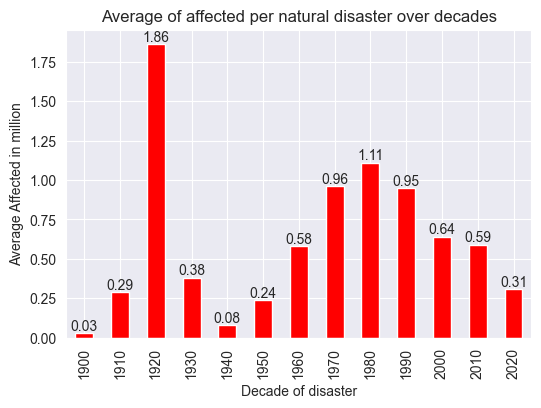

C:\Users\Koffe\AppData\Local\Temp\ipykernel_11436\3974925333.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medians_aff = round(df_a.groupby(["Disaster_Decade"]).median()['Total_Affected']/1_000,2)


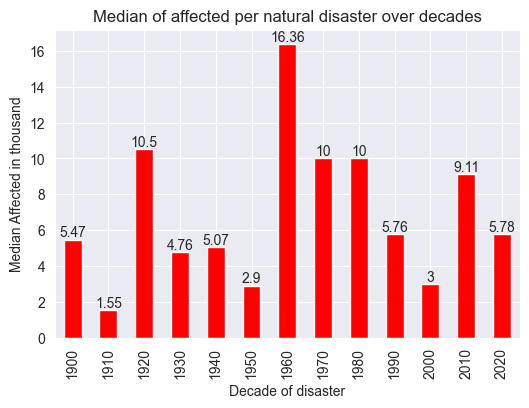

Disaster_Decade
1900     5.47
1910     1.55
1920    10.50
1930     4.76
1940     5.07
1950     2.90
1960    16.36
1970    10.00
1980    10.00
1990     5.76
2000     3.00
2010     9.11
2020     5.78
Name: Total_Affected, dtype: float64


In [52]:
# calc mean affected, per Decade and plot them in a bar plot
means_aff = round(df_a.groupby(["Disaster_Decade"]).mean()['Total_Affected'].round()/1_000_000,2)
#plt.subplot(1, 2,1)
ax = means_aff.plot(kind = 'bar', figsize = (6,4), color ="red")
ax.set_ylabel('Average Affected in million')
ax.set_xlabel ('Decade of disaster')
ax.set_title('Average of affected per natural disaster over decades')
print(means_aff)
ax.bar_label(ax.containers[0])
plt.show()

# calc median deaths, per Decade and plot them in a bar plot
medians_aff = round(df_a.groupby(["Disaster_Decade"]).median()['Total_Affected']/1_000,2)
#plt.subplot(1, 2,2)
plt.tight_layout()
ax = medians_aff.plot(kind = 'bar', figsize = (6,4), color ="red")
ax.set_ylabel('Median Affected in thousand')
ax.set_xlabel ('Decade of disaster')
ax.set_title('Median of affected per natural disaster over decades')
ax.bar_label(ax.containers[0])
plt.show()

print(medians_aff)

The number of affected shows a different picture than the one from the number of deaths. This supports our supposition, that less people die but that there are more and more people affected from natural disasters.

We take one quick look why the 1920 decade has so many deaths.

In [53]:
data_1920 = df_a.loc[df_a["Disaster_Decade"]==1920]
data_1920.nlargest(6,"Total_Deaths")
#df_a.nlargest(15,"Total_Deaths")

,Disaster_Group,Disaster_Subgroup,Disaster_Type,Disaster_Subtype,Disaster_Subsubtype,Country,ISO,Region,Continent,Associated_Dis,Associated_Dis2,Start_Year,End_Year,Total_Deaths,Total_Affected,Disaster_Decade
96,Natural,Climatological,Drought,Drought,<NA>,China,CHN,Eastern Asia,Asia,<NA>,<NA>,1928,1928,3000000.0,NaN,1920
58,Natural,Biological,Epidemic,Bacterial disease,<NA>,India,IND,Southern Asia,Asia,<NA>,<NA>,1920,1920,2000000.0,NaN,1920
906,Natural,Climatological,Drought,Drought,<NA>,Soviet Union,SUN,Russian Federation,Europe,Crop failure,Famine,1921,1921,1200000.0,5000000.0,1920
56,Natural,Climatological,Drought,Drought,<NA>,China,CHN,Eastern Asia,Asia,<NA>,<NA>,1920,1920,500000.0,20000000.0,1920
59,Natural,Biological,Epidemic,Bacterial disease,<NA>,India,IND,Southern Asia,Asia,<NA>,<NA>,1920,1920,500000.0,NaN,1920
85,Natural,Biological,Epidemic,Viral disease,<NA>,India,IND,Southern Asia,Asia,<NA>,<NA>,1926,1926,423000.0,NaN,1920


Up until now we have used "Start_Year" as the relevant year. Now let's look at how the results change if we distribute the deaths per event equally over all years (from "Start_Year" to "End_Year)

In [54]:
df_a_deaths = get_yearly_deaths(df_a, include_zero=True).to_frame().reset_index()
df_a_deaths = df_a_deaths[(df_a_deaths['Year'] != 2022)] # filter out data from 2022
# new column (decade)
df_a_deaths['Disaster_Decade'] = df_a_deaths['Year']//10*10 
df_a_deaths = df_a_deaths.astype({"Total_Deaths": np.float64, "Year": np.int32, "Disaster_Decade":np.int32})
df_a_deaths.sum()['Total_Deaths']/(df_a_deaths.max()['Year']-df_a_deaths.min()['Year']+1)# check, daran verändert sich nichts
#df_a_deaths

106593.0081967213

Text(0.5, 1.0, ' Deaths per year from natural disaster')

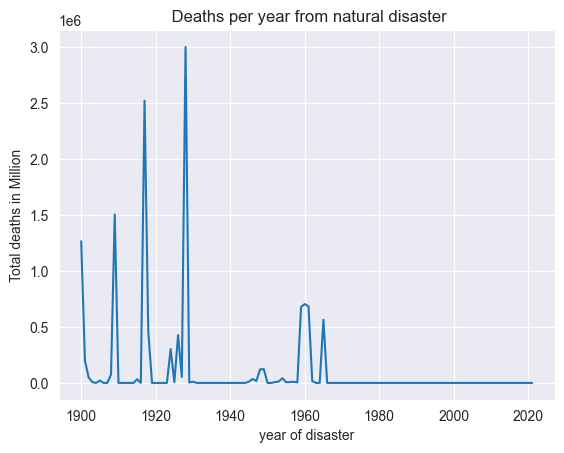

In [55]:
# calc mean deaths, per year and plot them in a bar plot

dth_distr = df_a_deaths.groupby(["Year"]).sum()['Total_Deaths'].round()
ax = dth_distr.plot(kind = 'line')
ax.set_ylabel('Total deaths in Million')
ax.set_xlabel ('year of disaster')
ax.set_title(' Deaths per year from natural disaster')

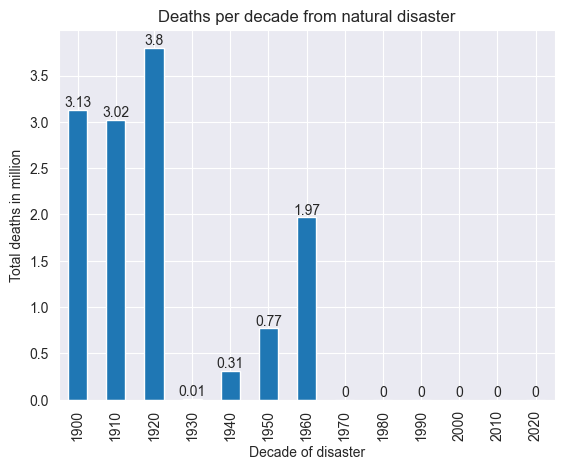

In [56]:
# calc deaths per Decade and plot them in a bar plot
sum_distr = round(df_a_deaths.groupby(["Disaster_Decade"]).sum()['Total_Deaths']/1_000_000,2)
ax = sum_distr.plot(kind = 'bar')
ax.set_ylabel('Total deaths in million')
ax.set_xlabel ('Decade of disaster')
ax.set_title('Deaths per decade from natural disaster')
ax.bar_label(ax.containers[0])
plt.show()

### Conclusions:
The average/median number of deaths per natural disaster over the last century has definitly decreased.
The number of deaths per decade has also decreased over the last 122 years. (Always keepining in mind, that the 2020 decade only contains 2 years, not ten as the others.
The number of natural disasters itself and also the average/median number of people affected per natural disasters however has increased.

Trend Analysis: Have a look, why the number of deaths in the 1920th is so high (5 from the 15 biggest disasters happend in the 1920th)

- Drought in China (1928): more political than natural (warlords using grain for themselves, less production due to opium plantation); Reference: https://disasterhistory.org/the-northwest-china-famine-1928-1930

- Epidemic in India (1920): Encephalitis lethargica; Reference https://simplifiedupsc.in/epidemics-that-have-hit-india-since-1900/

- Drought in Soviet Union (1921): natural and human caused - (Civil War, Russian Revolution: confiscation of stored grain) ; Reference: https://www.norkarussia.info/famine-1921-1924.html

- Viral disease (1926): Spanish flu brought back from soldiers; Reference: https://simplifiedupsc.in/epidemics-that-have-hit-india-since-1900/

- Drought in China (1920): rainless 12 months - total failure of Harvest; Reference: http://disasterhistory.org/north-china-famine-1920-21

Natural disasters in the early 1920s are partly also consequences of the first world war.

## 2. How does this vary by country? How does this vary by type of natural disaster?  

## 3. Are there trends visible that could be due to climate change?
Responsible: Moritz Renkin (11807211)

Dumping all data before 1950 as it is not relevant to climate change.

In [57]:
cutoff_year = 1950 # TODO check
df_climate = df_transformed[df_transformed["Start_Year"] >= cutoff_year]
min_year = df_climate["Start_Year"].min()
max_year = df_climate["Start_Year"].max()

yearly_global_temp = yearly_global_temp[yearly_global_temp.index >= cutoff_year]

Dumping extra-terrestrial and geophysical disasters can be assumed to be indifferent to climate change

In [58]:
df_climate = df_climate[(df_climate["Disaster_Subgroup"] != "Extra-terrestrial") & (df_climate["Disaster_Subgroup"] != "Geophysical")]
yearly_disaster_deaths = get_yearly_deaths(df_climate, include_zero=True) # remove

## Regarding Groupby and Pandas Datatypes

Pandas usually uses numpy datatypes. However, **numpy integer arrays do not allow for null values (np.nan)**. That's why pandas introduces their own Integer array, which can inlcude null values (pd.NA). However, for groupby operations these pd.NA values can cause problems, so it is advisable to convert back to a numpy float array (which does allow for np.nan) before applying the groupby.

In [59]:
groupby_base = df_climate.astype({"Total_Deaths": np.float64, "Total_Affected": np.float64, "Start_Year": np.int32, "Disaster_Decade": np.int32})
groupby_base = groupby_base[groupby_base["Disaster_Decade"] < 2020]
groupby_base[["Disaster_Subgroup", "Total_Deaths"]].groupby(["Disaster_Subgroup"]).mean()

,Total_Deaths
Disaster_Subgroup,
Biological,215.214689
Climatological,9342.864979
Hydrological,554.114710
Meteorological,332.690490


## Data Exploration

In [60]:
year_range = range(min_year, max_year)

def fill_missing_year():
    set(groupby_base.groupby("Start_Year").size().rename("No_Disasters").index).difference(year_range)
    # TODO

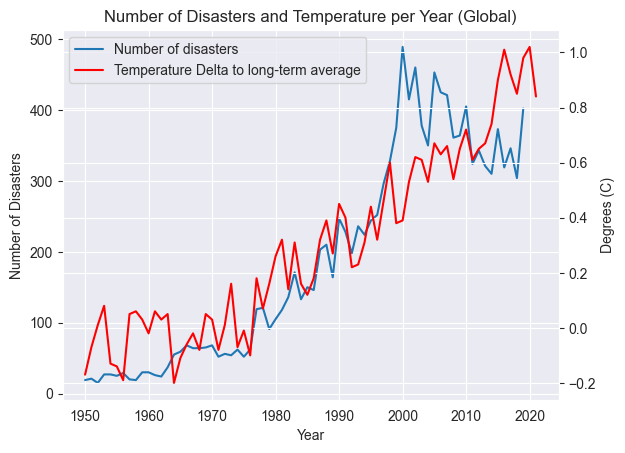

Correlation Coefficient: 0.8886333511376328


In [61]:
total_disaster_per_year = get_yearly_disaster_count(groupby_base, include_zero=True)

fig, ax_dis = plt.subplots()

plot_dis = ax_dis.plot(total_disaster_per_year.index, total_disaster_per_year, label="Number of disasters")
ax_dis.set_ylabel("Number of Disasters")
ax_dis.set_xlabel("Year")
ax_temp = ax_dis.twinx()

plot_temp = ax_temp.plot(yearly_global_temp.index, yearly_global_temp["Temperature Delta"], color="r", label="Temperature Delta to long-term average")
ax_temp.set_ylabel("Degrees (C)")

plots = plot_dis + plot_temp
plt.legend(plots, [plot.get_label() for plot in plots])
plt.title("Number of Disasters and Temperature per Year (Global)")

plt.show()
print(f"Correlation Coefficient: {total_disaster_per_year.corr(yearly_global_temp['Temperature Delta'])}")

The plot above shows that there has been an overall increase in the number of yearly disaster occurrences in the considered time frame.
At the same time, there is a trend of increasing global temperature.
The correlation between the two values over the considered time frame is quite high, but this correlation does not prove a causal influence.
We will be looking exploring general trends in the different disaster subgroups/types before trying to relate them to climate change.

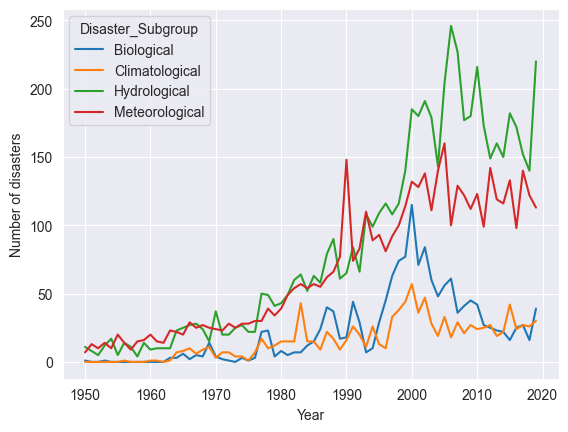

In [62]:
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Subgroup"]).reset_index(),
             x="Start_Year",
             y="No_Disasters",
             hue="Disaster_Subgroup")
plt.ylabel("Number of disasters")
plt.xlabel("Year")
plt.title("") # TODO
plt.show()

<AxesSubplot: xlabel='Start_Year', ylabel='No_Disasters'>

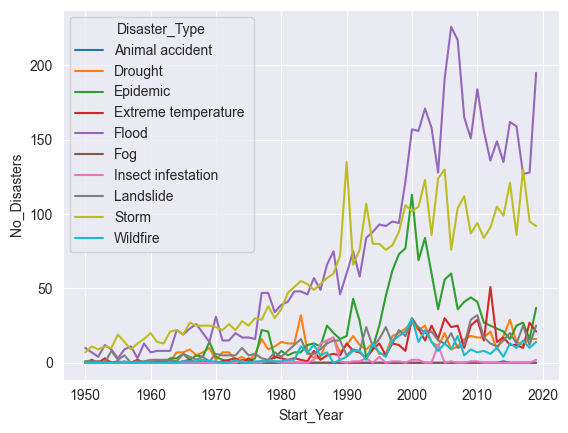

In [63]:
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Type"]).reset_index(),
             x="Start_Year",
             y="No_Disasters",
             hue="Disaster_Type")

### Global trends related to rising temperature

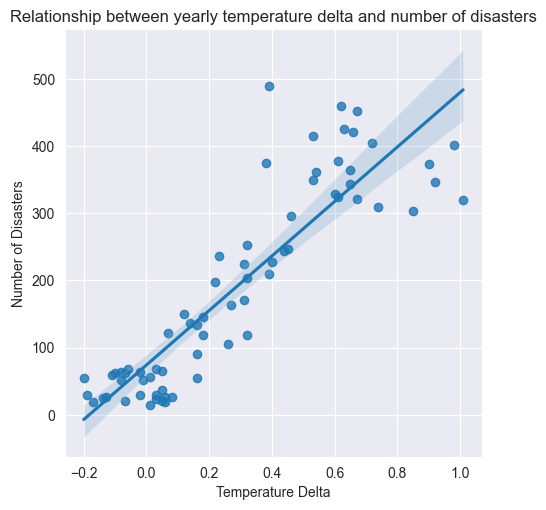

Correlation coefficient: 0.8886333511376328


In [64]:
yearly_temp_disasters = pd.concat((yearly_global_temp, get_yearly_disaster_count(groupby_base)), axis="columns")#.rename_axis("Year")
yearly_temp_disasters["Disaster_Decade"] = yearly_temp_disasters.index//10*10
sns.lmplot(data=yearly_temp_disasters,
           x="Temperature Delta",
           y="No_Disasters")
plt.xlabel("Temperature Delta")
plt.ylabel("Number of Disasters")
plt.title("Relationship between yearly temperature delta and number of disasters")
plt.show()
print(f"Correlation coefficient: {yearly_temp_disasters['Temperature Delta'].corr(yearly_temp_disasters['No_Disasters'])}")

In the graph above, a linear regression is depicted to show the supposed impact of rising temperatures on the number of natural disaster occurrences. Specially, the linear regression is performed on the global temperature delta of a given year to long-term average (x-axis) and the Number of natural disasters in that year (y-axis).

Text(54.09334852430557, 0.5, 'Number of disasters')

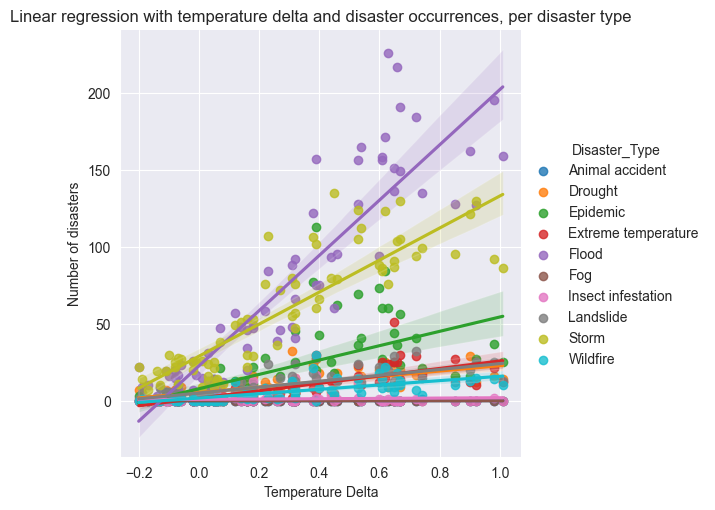

In [65]:
yearly_disaster_temp_by_subgroup: pd.DataFrame = get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Type"]).to_frame()
yearly_disaster_temp_by_subgroup["Temperature Delta"] = 0
yearly_disaster_temp_by_subgroup["Temperature Delta"] = yearly_disaster_temp_by_subgroup["Temperature Delta"].add(yearly_temp_disasters["Temperature Delta"].rename_axis(index="Start_Year"))#.groupby("Disaster_Decade")["Temperature Delta"].mean().drop(2020))
yearly_disaster_temp_by_subgroup.reset_index(inplace=True)

sns.lmplot(data=yearly_disaster_temp_by_subgroup,
           x="Temperature Delta",
           y="No_Disasters",
           hue="Disaster_Type")
plt.title("Linear regression with temperature delta and disaster occurrences, per disaster type")
plt.ylabel("Number of disasters")

Similar to the previous graph, this one tries to show the relationship between increasing temperature and the number of disaster occurrences. For this graphic, though, the regression is performed for each disaster type independently. It has to be noted that the natural disaster occurrences here are in **absolute** numbers, not relative to a long-term average or similar.
Disaster type "Flood" and "Storm" have the steepest slope which corresponds to their linear regression coefficients. Note that this does not mean that they also are the most strongly correlated to temperature. We will investigate the correlation per disaster type next.

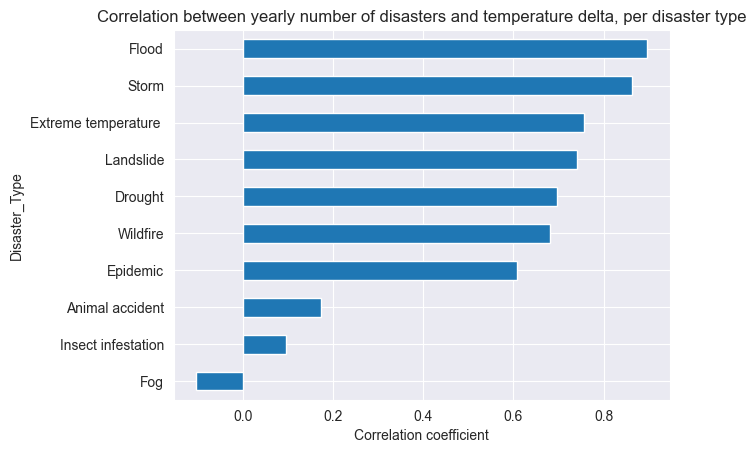

In [66]:
subgroup_correlations = yearly_disaster_temp_by_subgroup.groupby("Disaster_Type", as_index=True, group_keys=True).apply(lambda dis_type: dis_type["No_Disasters"].corr(dis_type["Temperature Delta"])).rename("Correlation").sort_values(ascending=True)
subgroup_correlations.plot.barh()
plt.xlabel("Correlation coefficient")
plt.title("Correlation between yearly number of disasters and temperature delta, per disaster type")
plt.show()

Similar to our linear regression models from before, flood and storm occurrences show the highest correlation to the yearly temperature, with both disaster types having a correlation coefficient higher than 0.8.

As noted before, **no causal influence can be assumed due to a strong correlation alone**. We are merely looking at trends here.

### Country-specific trends due to temperature increase
In this section, we try to investigate a potential trend of specific countries and their respective frequency of disaster occurrences. The hypothesis is that Countries which experienced a relatively strong warming also have a stronger trend of more frequent natural disaster occurrences.
We calculate the linear regression coefficient for Year (X) and number disaster occurrences (y) as a measure of this trend. The result of this calculation is saved in the "Disaster Occurrence Trend" column shown below. The values of this column can be interpreted as an estimator for absolute yearly increase in disaster occurrences.

In [67]:
yearly_country_disasters = get_yearly_disaster_count(groupby_base, index_cols=["Start_Year", "Country"], include_zero=True)
disaster_occurrence_trend = yearly_country_disasters.groupby(level="Country", sort=False).apply(lambda country: linregress(country, country.index.get_level_values("Start_Year")).slope).rename("Disaster Occurrence Trend")


yearly_country_deaths = get_yearly_deaths(df_climate, custom_index=["Country"], include_zero=True)
disaster_death_trend = yearly_country_deaths.groupby(level="Country").apply(lambda country: linregress(country.index.get_level_values("Year"), country).slope).rename("Disaster Deaths Trend")

countries_complete = pd.concat((country_temp_delta, disaster_occurrence_trend, disaster_death_trend), axis="columns", join="inner")
countries_complete

,Region,Warming/Century,Uncertainty (±),Disaster Occurrence Trend,Disaster Deaths Trend
Country,,,,,
Afghanistan,Asia,3.32,0.34,4.642134,7.521014
Albania,Europe,1.97,0.28,13.169659,0.026770
Algeria,Africa,2.86,0.28,6.726465,0.861824
American Samoa,NaN,1.43,0.57,9.584615,-0.053058
Angola,Africa,1.61,0.34,8.512264,3.708808
...,...,...,...,...,...
Uruguay,South America,1.56,0.45,13.841310,0.020194
Uzbekistan,Asia,2.72,0.29,16.969697,0.040067
Yemen,Asia,2.50,0.55,10.784651,1.871374


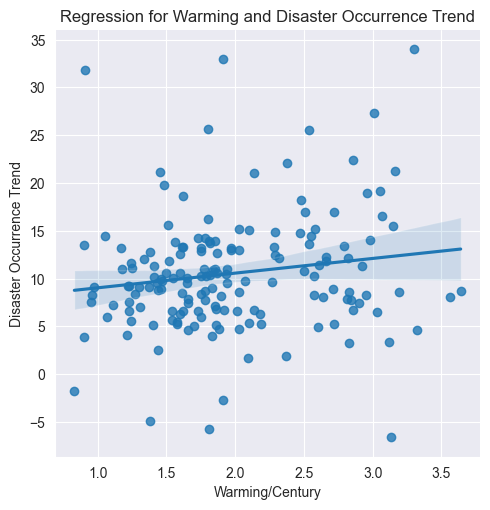

Correlation coefficient: 0.15749030996600916


In [68]:
sns.lmplot(data=countries_complete,
           x="Warming/Century",
           y="Disaster Occurrence Trend")
plt.title("Regression for Warming and Disaster Occurrence Trend")
plt.show()
print(f"Correlation coefficient: {countries_complete['Warming/Century'].corr(countries_complete['Disaster Occurrence Trend'])}")

It is pretty obvious that from the scatter plot and regression above that with our chosen method, no influence of a countries warming and disaster occurrence trend can be shown. The correlation coefficient of these two measures is low with ~0.15. Our initial hypothesis is not supported by the data.

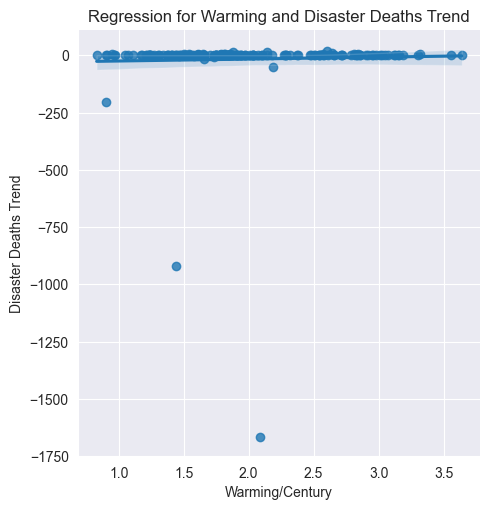

Correlation coefficient: 0.03559746650374376


In [69]:
sns.lmplot(data=countries_complete,
           x="Warming/Century",
           y="Disaster Deaths Trend")
plt.title("Regression for Warming and Disaster Deaths Trend")
plt.show()
print(f"Correlation coefficient: {countries_complete['Warming/Century'].corr(countries_complete['Disaster Deaths Trend'])}")

## Appendix
### Disaster Classification according to EM-DAT

Sourced from https://public.emdat.be/about.

<table style="border: 1px solid lightgray;float:left;">
    <tbody>
        <tr>
            <td>
                <p><strong>Disaster </strong></p>
                <p><strong>Group</strong></p>
            </td>
            <td>
                <p><strong>Disaster </strong></p>
                <p><strong>Sub-Group</strong></p>
            </td>
            <td>
                <p><strong>Disaster </strong></p>
                <p><strong>Type</strong></p>
            </td>
            <td>
                <p><strong>Disaster </strong></p>
                <p><strong>Sub-Type</strong></p>
            </td>
            <td>
                <p><strong>Disaster </strong></p>
                <p><strong>Sub-Sub Type</strong></p>
            </td>
        </tr>
        <tr>
            <td>
                <p><strong>Natural</strong></p>
            </td>
            <td>
                <p>Geophysical</p>
            </td>
            <td>
                <p>Earthquake</p>
            </td>
            <td>
                <p>Ground movement</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Tsunami</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Volcanic activity</p>
            </td>
            <td>
                <p>Ash fall</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Lahar</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Pyroclastic flow</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Lava flow</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Mass Movement</p>
            </td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td>
                <p>Meteorological</p>
            </td>
            <td>
                <p>Storm</p>
            </td>
            <td>
                <p>Tropical storm</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Extra-tropical storm</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Convective storm</p>
            </td>
            <td>
                <p>Derecho</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Hail</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Lightning/thunderstorm</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Rain</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Tornado</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Sand/dust storm</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Winter storm/blizzard</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Storm/surge</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Wind</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Severe Storm</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Extreme Temperature</p>
            </td>
            <td>
                <p>Cold wave</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Heat Wave</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Severe winter conditions</p>
            </td>
            <td>
                <p>Snow/ice</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Frost/freeze</p>
            </td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Fog</p>
            </td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td>
                <p>Hydrological</p>
            </td>
            <td>
                <p>Flood</p>
            </td>
            <td>
                <p>Coastal flood</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Riverine flood</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Flash flood</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Ice jam flood</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Landslide</p>
            </td>
            <td>
                <p>Avalanche (snow, debris, mudflow, rock fall)</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Wave action</p>
            </td>
            <td>
                <p>Rogue wave</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Seiche</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td>
                <p>Climatological</p>
            </td>
            <td>
                <p>Drought</p>
            </td>
            <td>
                <p>Drought</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Glacial Lake outburst</p>
            </td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Wildfire</p>
            </td>
            <td>
                <p>Forest fires</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Land fire: Brush, bush, pasture</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td>
                <p>Biological</p>
            </td>
            <td>
                <p>Epidemic</p>
            </td>
            <td>
                <p>Viral diseases</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Bacterial diseases</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Parasitic diseases</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Fungal diseases</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Prion diseases</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Insect Infestation</p>
            </td>
            <td>
                <p>Locust</p>
                <p>Grasshopper</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Animal accident</p>
            </td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td>
                <p>Extra-terrestrial</p>
            </td>
            <td>
                <p>Impact</p>
            </td>
            <td>
                <p>Airburst</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>
                <p>Space weather</p>
            </td>
            <td>
                <p>Energic particles</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Geomagnetic storm</p>
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
            <td>
                <p>Shockwave</p>
            </td>
            <td></td>
        </tr>
    </tbody>
</table>